In [1]:
import json
from collections import defaultdict
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import pandas as pd
from rliable import plot_utils
plt.rcParams['text.usetex'] = False #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = r'\usepackage{sansmath} \sansmath' #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helveta Nue'] # Choose a nice font here
sns.set_style("whitegrid")

COLORS = ['#BBCC33', '#77AADD', '#44BB99',
           '#EEDD88', '#EE8866', '#FFAABB',
          '#99DDFF', '#44BB99', '#AAAA00',
          '#DDDDDD']
palette = sns.set_palette(COLORS)

/home/cmu/miniconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('aime.csv')

In [3]:
# Filter for year 2025
df_2025 = df[df['years'] == '2025'].copy()

# Extract model name (without org prefix)
df_2025['model_name'] = df_2025['model'].apply(lambda x: x.split('/')[-1])

# Reshape the dataframe for seaborn barplot (grouped by model_name)
melted = pd.melt(
    df_2025,
    id_vars=['model_name'],
    value_vars=['pass_at_1_4096', 'pass_at_1_8192', 'pass_at_1_16384', 'pass_at_1_32768'],
    var_name='context_length',
    value_name='pass_rate'
)

# Map corresponding error values
error_map = {
    'pass_at_1_4096': 'pass_at_1_err_4096',
    'pass_at_1_8192': 'pass_at_1_err_8192',
    'pass_at_1_16384': 'pass_at_1_err_16384',
    'pass_at_1_32768': 'pass_at_1_err_32768'
}

# Add error column
melted['error'] = melted.apply(lambda row: df_2025.loc[
    df_2025['model_name'] == row['model_name'], error_map[row['context_length']]
].values[0], axis=1)

# Simplify context length labels
melted['context_length'] = melted['context_length'].str.extract(r'(\d+)$')

/tmp/ipykernel_828436/3885276337.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=melted, x='model_name', y='pass_rate', hue='context_length', order=model_order, ci=None)


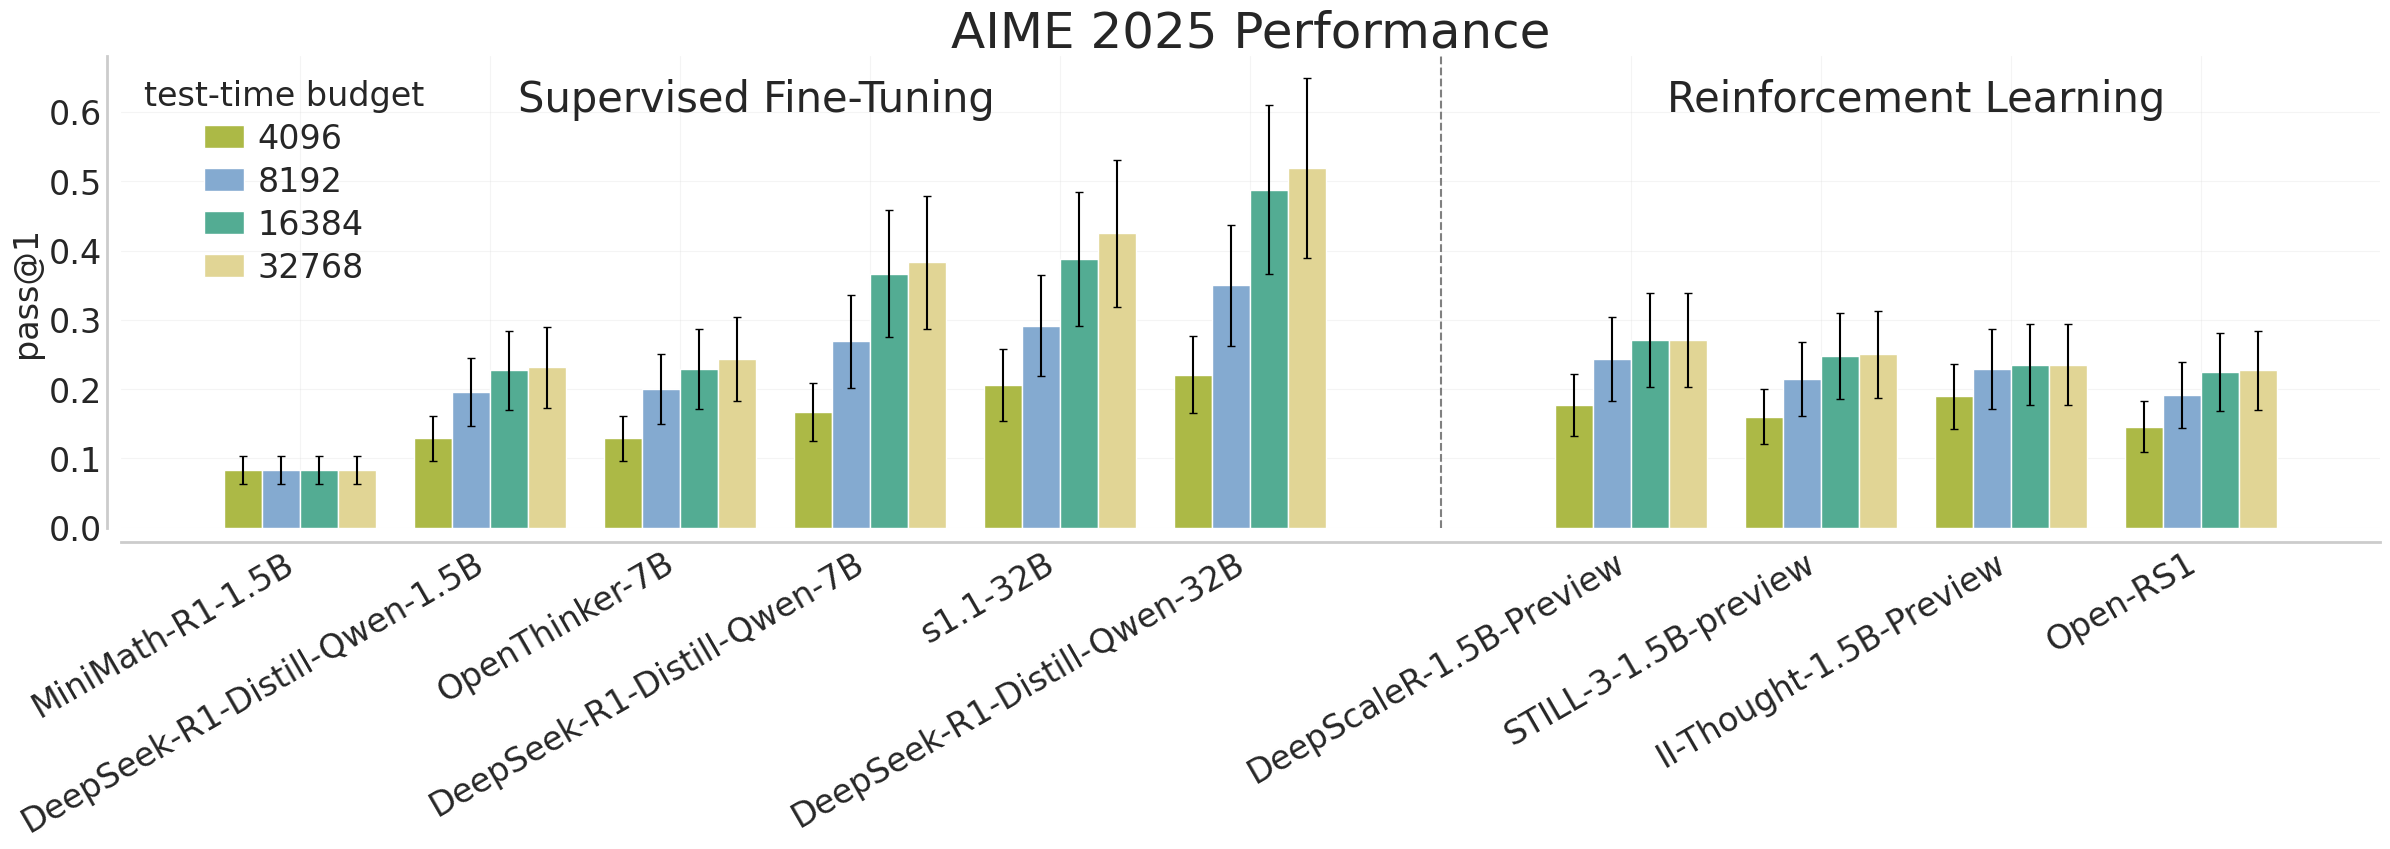

In [4]:
model_order = [
    "MiniMath-R1-1.5B",
    "DeepSeek-R1-Distill-Qwen-1.5B",
    "OpenThinker-7B",
    "DeepSeek-R1-Distill-Qwen-7B",
    "s1.1-32B",
    "DeepSeek-R1-Distill-Qwen-32B",
    "",  # This empty string is a trick if you want a separator visually
    "DeepScaleR-1.5B-Preview",
    "STILL-3-1.5B-preview",
    "II-Thought-1.5B-Preview",
    "Open-RS1"
]

# Plotting
plt.figure(figsize=(24, 6))

# Create barplot
ax = sns.barplot(data=melted, x='model_name', y='pass_rate', hue='context_length', order=model_order, ci=None)

# Add manual error bars
context_order = ['4096', '8192', '16384', '32768']
n_contexts = len(context_order)
bar_width = 0.8 / n_contexts

for i, model in enumerate(model_order):
    for j, context in enumerate(context_order):
        subset = melted[(melted['model_name'] == model) & (melted['context_length'] == context)]
        if not subset.empty:
            y = subset['pass_rate'].values[0]
            yerr = subset['error'].values[0]
            x_pos = i - 0.4 + j * bar_width + bar_width / 2
            ax.errorbar(x=x_pos, y=y, yerr=yerr, fmt='none', c='black', capsize=3)

plot_utils._annotate_and_decorate_axis(ax,
                                        # xlabel='model',
                                        ylabel='pass@1',
                                        labelsize=24,
                                        ticklabelsize=24,
                                        grid_alpha=0.2,
                                        legend=True)
ax.legend(
        prop={'size': 24},         # Slightly smaller font
        title='test-time budget',
        title_fontsize=24,
        loc='upper left',          # Legend position
        ncol=1,                    # Keep 1 column
        frameon=False,             # No box
        handlelength=1.2,          # Shrink line length
        handletextpad=0.4,         # Shrink space between marker and text
        borderpad=0.2,             # Shrink border padding inside legend box
        labelspacing=0.3,          # Reduce vertical space between entries
        markerscale=0.8,            # Shrink marker size
        # bbox_to_anchor=(-0.1, 1)
    )


# Final formatting
plt.title('AIME 2025 Performance', fontsize=36)
plt.tight_layout()

plt.axvline(x=6, color='gray', linestyle='--')

plt.text(2.4, 0.6, "Supervised Fine-Tuning", fontsize=30, ha='center')
plt.text(8.5, 0.6, "Reinforcement Learning", fontsize=30, ha='center')

plt.xticks(ticks=range(len(model_order)), labels=model_order, rotation=30, ha='right')
plt.savefig("aime.pdf", bbox_inches='tight',pad_inches=0, dpi=300)
plt.show()

### Line plot

In [5]:
df = pd.read_csv('aime.csv')
df = df[df['years'] == '2025'].copy()

In [6]:
df['model']

1        deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B
3             agentica-org/DeepScaleR-1.5B-Preview
5                   RUC-AIBOX/STILL-3-1.5B-preview
7     Intelligent-Internet/II-Thought-1.5B-Preview
9                               knoveleng/Open-RS1
11                        oumi-ai/MiniMath-R1-1.5B
13         deepseek-ai/DeepSeek-R1-Distill-Qwen-7B
15                    open-thoughts/OpenThinker-7B
17        deepseek-ai/DeepSeek-R1-Distill-Qwen-32B
19                          simplescaling/s1.1-32B
Name: model, dtype: object

/tmp/ipykernel_828436/4169784118.py:59: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.lineplot(data=filtered_df, x="budget", y="pass_at_1", hue="model", linewidth=3, ax=ax, marker="X", markersize=8, linestyle=':', palette=COLORS[:3])
/tmp/ipykernel_828436/4169784118.py:62: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.lineplot(data=filtered_df, x="budget", y="pass_at_1", hue="model", linewidth=3, ax=ax, marker="X", markersize=8, palette=COLORS[3:])


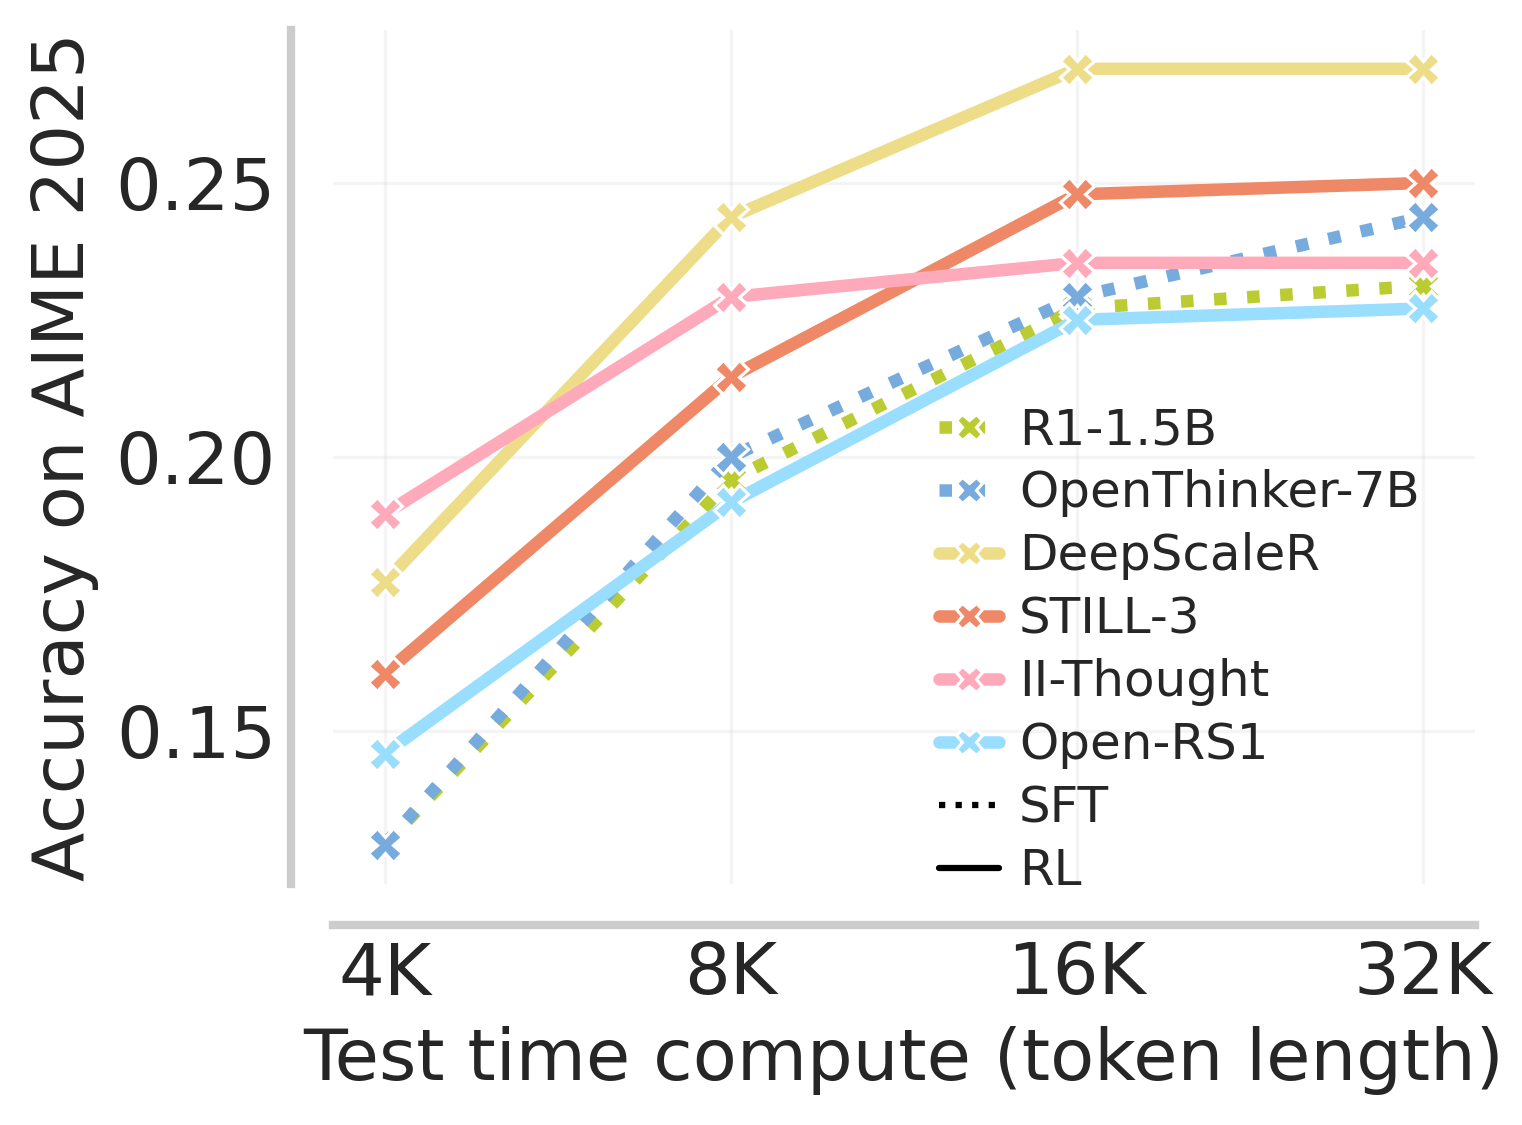

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=300)
fig.set_size_inches(496.0/192*2, 369.6/192*2)

# Extract relevant budgets
budgets = [4096, 8192, 16384, 32768]
plot_data = []

# Define models to include
model_order = [
    "R1-1.5B",
    "DeepScaleR",
    "STILL-3",
    "II-Thought",
    "Open-RS1"
    "OpenThinker-7B",
    # "DeepSeek-R1-Distill-Qwen-7B",
]

name_to_display_name = {
    "DeepSeek-R1-Distill-Qwen-1.5B": "R1-1.5B",
    "DeepScaleR-1.5B-Preview": "DeepScaleR",
    "STILL-3-1.5B-preview": "STILL-3",
    "II-Thought-1.5B-Preview": "II-Thought",
    "Open-RS1": "Open-RS1",
    "OpenThinker-7B": "OpenThinker-7B",
    # "DeepSeek-R1-Distill-Qwen-7B": "DeepSeek-R1-7B",
}

SFT_models = {
    "R1-1.5B",
    "OpenThinker-7B",
    "DeepSeek-R1-7B",
}

RL_models = {
    "DeepScaleR",
    "STILL-3",
    "II-Thought",
    "Open-RS1"
}

# Create long-form data for plotting
for budget in budgets:
    for i, row in df.iterrows():
        model_name = row["model"].split("/")[-1]  # Remove org name
        if model_name not in name_to_display_name:
            continue
        plot_data.append({
            "budget": budget,
            "pass_at_1": row[f"pass_at_1_{budget}"],
            "model": name_to_display_name[model_name],
        })

# Convert to DataFrame
long_df = pd.DataFrame(plot_data)

# Filter to only include the specified models
filtered_df = long_df[long_df["model"].isin(SFT_models)]
sns.lineplot(data=filtered_df, x="budget", y="pass_at_1", hue="model", linewidth=3, ax=ax, marker="X", markersize=8, linestyle=':', palette=COLORS[:3])

filtered_df = long_df[long_df["model"].isin(RL_models)]
sns.lineplot(data=filtered_df, x="budget", y="pass_at_1", hue="model", linewidth=3, ax=ax, marker="X", markersize=8, palette=COLORS[3:])

sns.lineplot(x=[5000], y=[0.2], label="SFT", color='black', linestyle=':')
sns.lineplot(x=[5000], y=[0.2], label="RL", color='black', linestyle='-')

plot_utils._annotate_and_decorate_axis(ax,
                                        xlabel='Test time compute (token length)',
                                        ylabel='Accuracy on AIME 2025',
                                        labelsize='xx-large',
                                        ticklabelsize='xx-large',
                                        grid_alpha=0.2,
                                        legend=True)


ax.legend(
        prop={'size': 'large'},         # Slightly smaller font
        ncol=1,                    # Keep 1 column
        frameon=False,             # No box
        handlelength=1.2,          # Shrink line length
        handletextpad=0.4,         # Shrink space between marker and text
        borderpad=0.2,             # Shrink border padding inside legend box
        labelspacing=0.3,          # Reduce vertical space between entries
        # loc="center right",                # Optional: auto position
        markerscale=0.8,            # Shrink marker size
        bbox_to_anchor=(0.5, 0.6)
    )

# Plot with log2 x-axis
plt.xscale("log", base=2)
plt.xticks([2**12, 2**13, 2**14, 2**15], labels=[r"4K", r"8K", r"16K", r"32K"])
plt.tight_layout()

plt.savefig("aime_line.pdf", bbox_inches='tight')

plt.show()
